<a href="https://colab.research.google.com/github/kumuds4/BCH/blob/master/Making_the_Most_of_your_Colab_Subscription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making the Most of your Colab Subscription



# Access Popular LLMs via Google-Colab-AI Without an API Key

Users with Colab's paid plans have free access to most popular LLMs via google-colab-ai Python library. For more details, refer to the [getting started with google colab ai](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/Getting_started_with_google_colab_ai.ipynb).

In [ ]:
from google.colab import ai
response = ai.generate_text("What is the capital of France?")
print(response)

## Faster GPUs

Users who have purchased one of Colab's paid plans have access to faster GPUs and more memory. You can upgrade your notebook's GPU settings in `Runtime > Change runtime type` in the menu to select from several accelerator options, subject to availability.

The free of charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is "Not connected to a GPU", you can change the runtime by going to `Runtime > Change runtime type` in the menu to enable a GPU accelerator, and then re-execute the code cell.


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In order to use a GPU with your notebook, select the `Runtime > Change runtime type` menu, and then set the hardware accelerator to the desired option.

## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available. More powerful GPUs are always offered with high-memory VMs.



You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is "Not using a high-RAM runtime", then you can enable a high-RAM runtime via `Runtime > Change runtime type` in the menu. Then select High-RAM in the Runtime shape toggle button. After, re-execute the code cell.


In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

## Longer runtimes

All Colab runtimes are reset after some period of time (which is faster if the runtime isn't executing code). Colab Pro and Pro+ users have access to longer runtimes than those who use Colab free of charge.

## Background execution

Colab Pro+ users have access to background execution, where notebooks will continue executing even after you've closed a browser tab. This is always enabled in Pro+ runtimes as long as you have compute units available.



## Relaxing resource limits in Colab Pro

Your resources are not unlimited in Colab. To make the most of Colab, avoid using resources when you don't need them. For example, only use a GPU when required and close Colab tabs when finished.



If you encounter limitations, you can relax those limitations by purchasing more compute units via Pay As You Go. Anyone can purchase compute units via [Pay As You Go](https://colab.research.google.com/signup); no subscription is required.

## Send us feedback!

If you have any feedback for us, please let us know. The best way to send feedback is by using the Help > 'Send feedback...' menu. If you encounter usage limits in Colab Pro consider subscribing to Pro+.

If you encounter errors or other issues with billing (payments) for Colab Pro, Pro+, or Pay As You Go, please email [colab-billing@google.com](mailto:colab-billing@google.com).

## More Resources

### Working with Notebooks in Colab
- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<a name="working-with-data"></a>
### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)


<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TPUs in Colab](/notebooks/tpu.ipynb)

<a name="machine-learning-examples"></a>

## Machine Learning Examples

To see end-to-end examples of the interactive machine learning analyses that Colab makes possible, check out these tutorials using models from [TensorFlow Hub](https://tfhub.dev).

A few featured examples:

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.


Training set size: 1200
Validation set size: 200
Test set size: 600


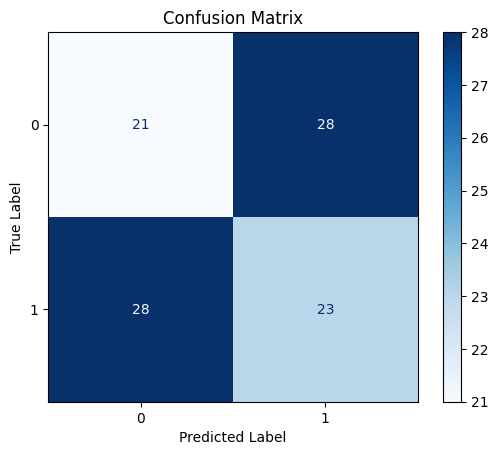

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Function to generate synthetic dataset
def generate_dataset(num_samples=2000):
    # Initialize lists
    features = []

    # Generate samples
    for _ in range(num_samples):
        # Randomize input variables based on ranges from the papers
        gamma = np.random.uniform(-10, 20)  # $\bar{\eta}$
        phi_T = np.random.uniform(0, 2 * np.pi)
        r_T = np.random.uniform(0, 1)
        q_T = np.random.uniform(0, 1)
        m_ST = 2.5
        m_tD = 2.5
        zeta_c = 2.5
        N = np.random.choice([15, 20, 30])
        delta_ST = 1
        delta_tD = 1
        A_th = 5

        # Calculate Cartesian coordinates
        x_T = r_T * np.sin(phi_T)
        y_T = r_T * np.cos(phi_T)
        z_T = q_T

        # Example variables a and b as source/destination coordinates
        x_a, y_a, z_a = -0.5, 0, 0
        x_b, y_b, z_b = 0.5, 0, 0
        distance = np.sqrt((x_a - x_T)**2 + (y_a - y_T)**2 + (z_a - z_T)**2)

        # Example feature vector
        feature_vector = [gamma, phi_T, r_T, q_T, m_ST, m_tD, zeta_c, N, delta_ST, delta_tD, A_th, distance]
        features.append(feature_vector)

    columns = ['gamma', 'phi_T', 'r_T', 'q_T', 'm_ST', 'm_tD', 'zeta_c', 'N', 'delta_ST', 'delta_tD', 'A_th', 'distance']
    dataset = pd.DataFrame(features, columns=columns)

    return dataset

# Generate the dataset
dataset = generate_dataset()

# Split the dataset into train, test, and validation sets
train, test = train_test_split(dataset, test_size=0.4, random_state=42)
test, val = train_test_split(test, test_size=0.25, random_state=42)  # 0.25 x 0.4 = 0.1

# Display dataset sizes
print(f"Training set size: {len(train)}")
print(f"Validation set size: {len(val)}")
print(f"Test set size: {len(test)}")

# Example of saving to CSV if needed
train.to_csv('train_data.csv', index=False)
val.to_csv('val_data.csv', index=False)
test.to_csv('test_data.csv', index=False)

# Plot confusion matrix
# Example true and predicted labels
y_true = np.random.randint(0, 2, 100)  # Replace with your actual true labels
y_pred = np.random.randint(0, 2, 100)  # Replace with your predicted labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a display for the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Generate synthetic dataset
def generate_dataset(num_samples=2000):
    features = []
    for _ in range(num_samples):
        gamma = np.random.uniform(-10, 20)
        phi_T = np.random.uniform(0, 2 * np.pi)
        r_T = np.random.uniform(0, 1)
        q_T = np.random.uniform(0, 1)
        m_ST = 2.5
        m_tD = 2.5
        zeta_c = 2.5
        N = np.random.choice([15, 20, 30])
        delta_ST = 1
        delta_tD = 1
        A_th = 5

        x_T = r_T * np.sin(phi_T)
        y_T = r_T * np.cos(phi_T)
        z_T = q_T
        x_a, y_a, z_a = -0.5, 0, 0
        x_b, y_b, z_b = 0.5, 0, 0
        distance = np.sqrt((x_a - x_T)**2 + (y_a - y_T)**2 + (z_a - z_T)**2)

        feature_vector = [gamma, phi_T, r_T, q_T, m_ST, m_tD, zeta_c, N, delta_ST, delta_tD, A_th, distance]
        features.append(feature_vector)

    columns = ['gamma', 'phi_T', 'r_T', 'q_T', 'm_ST', 'm_tD', 'zeta_c', 'N', 'delta_ST', 'delta_tD', 'A_th', 'distance']
    dataset = pd.DataFrame(features, columns=columns)

    return dataset

# Generate the dataset
dataset = generate_dataset()

# Split the dataset into train, test, and validation sets
train, test = train_test_split(dataset, test_size=0.4, random_state=42)
test, val = train_test_split(test, test_size=0.25, random_state=42)

# Define DNN model
#def create_dnn_model(input_shape):